# Global Equity Momentum Strategy Analysis

Hello everyone. I created this small research to finally answer my question: Is Global Equity Momentum (GEM) a valid strategy worth applying in real life?

## Global Equity Momentum

Global Equity Momentum (GEM) is a rules-based investment strategy formalized by Gary Antonacci in 2012. The strategy combines the equity risk premium with two known style premia: trend and momentum, to rotate between U.S. and foreign stocks while moving to bonds when U.S. stocks exhibit a negative trend.

GEM uses both relative momentum (comparing strength across different assets) and absolute momentum (looking for positive past returns exceeding Treasury bill returns). The original strategy applies a 12-month lookback period to evaluate performance and rebalances positions monthly. It typically rotates between three asset classes: the S&P 500 index, MSCI All Country World ex-US index, and Barclays Capital US Aggregate Bond index.

## In This Research

This simulation analyzes and compares the following strategies:

- Simplest Buy and Hold - A baseline passive investment approach
- GEM (Original) - Standard GEM using only the original three instruments — SPY, EEM and BND, with monthly rebalancing and a 12-month lookback
- GEM (Expanded Tickers): GEM using instruments: SPY, QQQ, TLT, IAU, BND, EEM, and EUM, testing broader momentum signals.
- GEM with 90-Day Rebalancing Period - Modified GEM reducing transaction frequency to quarterly rebalancing for both original and expanded ticker universes
- GEM with 3-Year Comparison Time Window - Alternative GEM using a 36-month lookback period instead of the traditional 12 months as well for original and expanded ticker universes

## Data

I compiled a CSV dataset containing daily close prices for seven instruments:

- **SPY** -  S&P 500 ETF
- **EEM** - MSCI Emerging Markets ETF
- **BND** - Total Bond Market Index Fund ETF

- **QQQ** - Nasdaq-100 ETF
- **IAU** - Gold Trust ETF
- **EUM** - MSCI EMU Index (European Economic and Monetary Union) ETF
- **TLT** - 20+ Year Treasury Bond ETF

The simulation begins on 2002-08-01, when SPY, QQQ, and TLT first had available prices. Additional tickers entered mid-simulation, expanding the algorithm's selection range over time. The dataset extends through 2025-01-31, containing over 5,500 daily records. Close prices are recorded for each available trading day, with zero values indicating unavailability.

### Data source 

- https://www.kaggle.com/datasets/benjaminpo/s-and-p-500-with-dividends-and-splits-daily-updated/data
- https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Reading data

In [24]:
df = pd.read_csv("data/gem.csv")
print(df.head())

         Date    SPY  EEM  IAU  BND    TLT    QQQ  EUM
0  2002-08-01  88.78  0.0  0.0  0.0  83.00  22.73  0.0
1  2002-08-02  86.79  0.0  0.0  0.0  83.85  22.25  0.0
2  2002-08-05  83.77  0.0  0.0  0.0  84.22  21.44  0.0
3  2002-08-06  86.59  0.0  0.0  0.0  83.50  22.50  0.0
4  2002-08-07  88.10  0.0  0.0  0.0  83.70  22.80  0.0


## Variables

The simulation is designed to evaluate the performance of different Global Equity Momentum (GEM) strategy variants based on configurable parameters:

- **REBALANCE_PERIOD**: Defines how often the portfolio is rebalanced to reflect current momentum signals (e.g., 90 days for quarterly rebalancing or monthly for standard GEM) (in days).
- **COMPARISON_TIME_WINDOW**: Sets the lookback period over which momentum is calculated, such as 12 months for classic GEM or 3 years in the extended variant (in days).
- **STARTING_CASH**: Specifies the initial capital available for investment in the simulation.

Both REBALANCE_PERIOD and COMPARISON_TIME_WINDOW are adjusted in the algorithm to account for the stock market being closed on Saturdays and Sundays (113 days in a year on average). This ensures that rebalancing and momentum calculations happen on valid trading days only, avoiding weekends and holidays.

In [25]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365  # in days
STARTING_CASH = 1000
ORIGINAL_TICKERS = ["BND", "EEM", "SPY"]
EXTENDED_TICKERS = ["BND", "EEM", "EUM", "IAU", "SPY", "QQQ", "TLT"]
TRADING_DAYS_IN_YEAR = 252

In [26]:
# Adjust days
def adjust_days(days: int) -> int:
    return int(days / 365 * TRADING_DAYS_IN_YEAR)

In [27]:
# Plot function
def plot(plot_values, plot_days, title):
    plt.figure(figsize=(12, 8))
    plt.plot(plot_days, plot_values, label="Portfolio Value", color="aqua", linewidth=2)
    plt.title(title, fontsize=18)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.xticks(plot_days[::8], rotation=45)
    plt.legend(loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

## Simplest Buy and Hold

The buy and hold strategy in this research uses the SPY as the sole investment instrument. Starting with an initial cash amount (STARTING_CASH), the entire capital is invested in SPY at the closing price on the day corresponding to the comparison time window. No further trading or rebalancing occurs, reflecting a pure long-term investment approach.

The portfolio value is then tracked at intervals defined by the rebalancing period. Although no active trades are made after the initial purchase, values are recorded periodically to enable direct comparison with momentum-based strategies. This method provides a performance baseline reflecting market returns from holding a broad U.S. equity index over the simulation period.

SPY is widely regarded as a proxy for the U.S. large-cap stock market and has historically delivered a compound annual return of approximately 10.5%, making it a common benchmark for investment strategies.

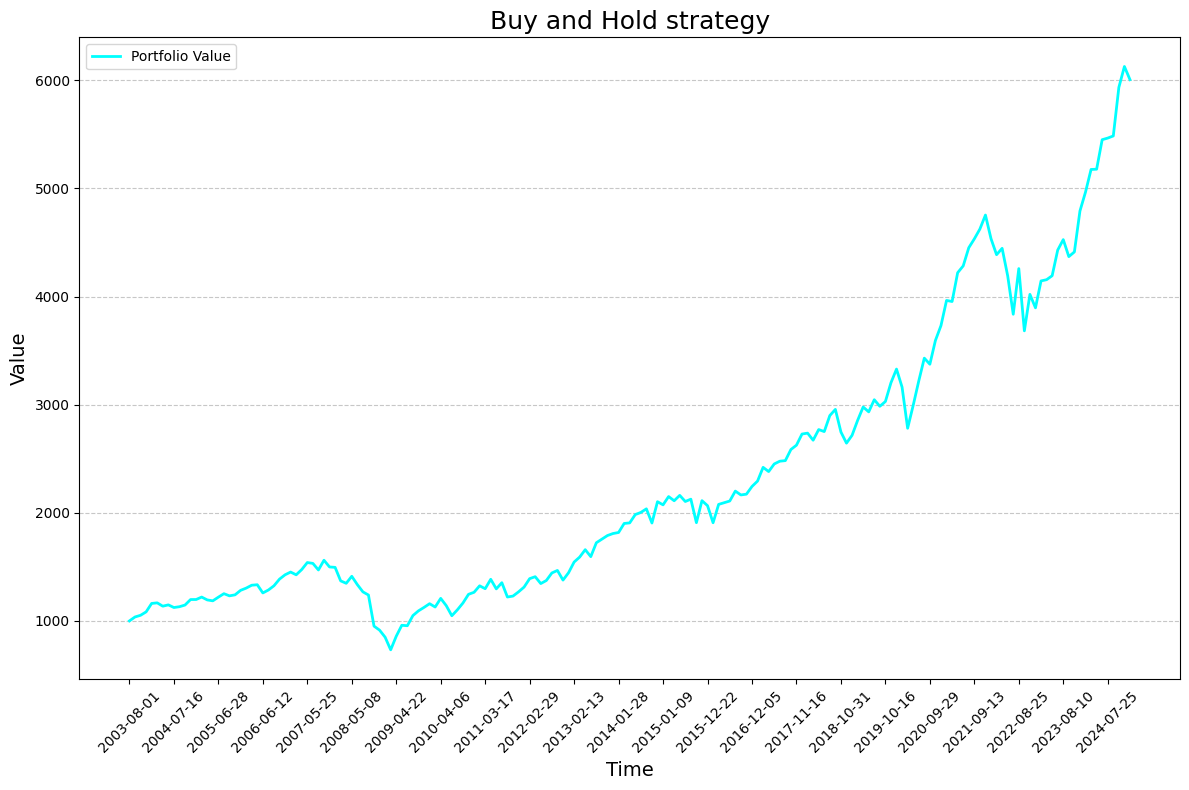

In [28]:
BUY_AND_HOLD_TICKER = "SPY"

cash = STARTING_CASH
buy_and_hold_values = []
buy_and_hold_days = []
amount = 0

adjust_time_window = adjust_days(COMPARISON_TIME_WINDOW)
adjust_rebalance_period = adjust_days(REBALANCE_PERIOD)

amount = cash / df.iloc[adjust_time_window][BUY_AND_HOLD_TICKER]
cash = 0

for i in range(adjust_time_window, len(df.index), REBALANCE_PERIOD):
    buy_and_hold_values.append(amount * df.iloc[i][BUY_AND_HOLD_TICKER])
    buy_and_hold_days.append(df.iloc[i]["Date"])

plot(buy_and_hold_values, buy_and_hold_days, "Buy and Hold strategy")

## GEM (Original)

The Global Equity Momentum (GEM) strategy, introduced by Gary Antonacci, systematically allocates capital to the asset class demonstrating the strongest relative performance over a fixed comparison time window. In its classic form, the algorithm considers only the original three instruments—SPY for U.S. equities, EEM for international equities, and BND for bonds. The portfolio is rebalanced at regular intervals (monthly or quarterly), shifting to the top-performing asset among these three. This dual momentum approach seeks to capture returns from strong trends in global equity and bond markets while reducing volatility and drawdowns compared to passive investing.

In [29]:
def gem_sim(
    rebalance_period,
    comparison_time_window,
    tickers=ORIGINAL_TICKERS,
    starting_cash=STARTING_CASH,
):
    cash = starting_cash
    values = []
    days = []
    asset = ""
    amount = 0

    rebalance_period = adjust_days(rebalance_period)
    comparison_time_window = adjust_days(comparison_time_window)

    for i in range(comparison_time_window, len(df.index), rebalance_period):
        value_change = {}
        for ticker in tickers:
            start_value = df.iloc[i - comparison_time_window][ticker]
            end_value = df.iloc[i][ticker]

            if start_value == 0:
                value_change[ticker] = -1
            else:
                value_change[ticker] = end_value / start_value - 1
        best_performer = max(value_change, key=value_change.get)

        if best_performer != asset:
            if asset == "":
                asset = best_performer
            else:
                cash = df.iloc[i][asset] * amount
            amount = cash / df.iloc[i][best_performer]
            asset = best_performer
            cash = 0

        values.append(amount * df.iloc[i][asset])
        days.append(df.iloc[i]["Date"])
    return values, days

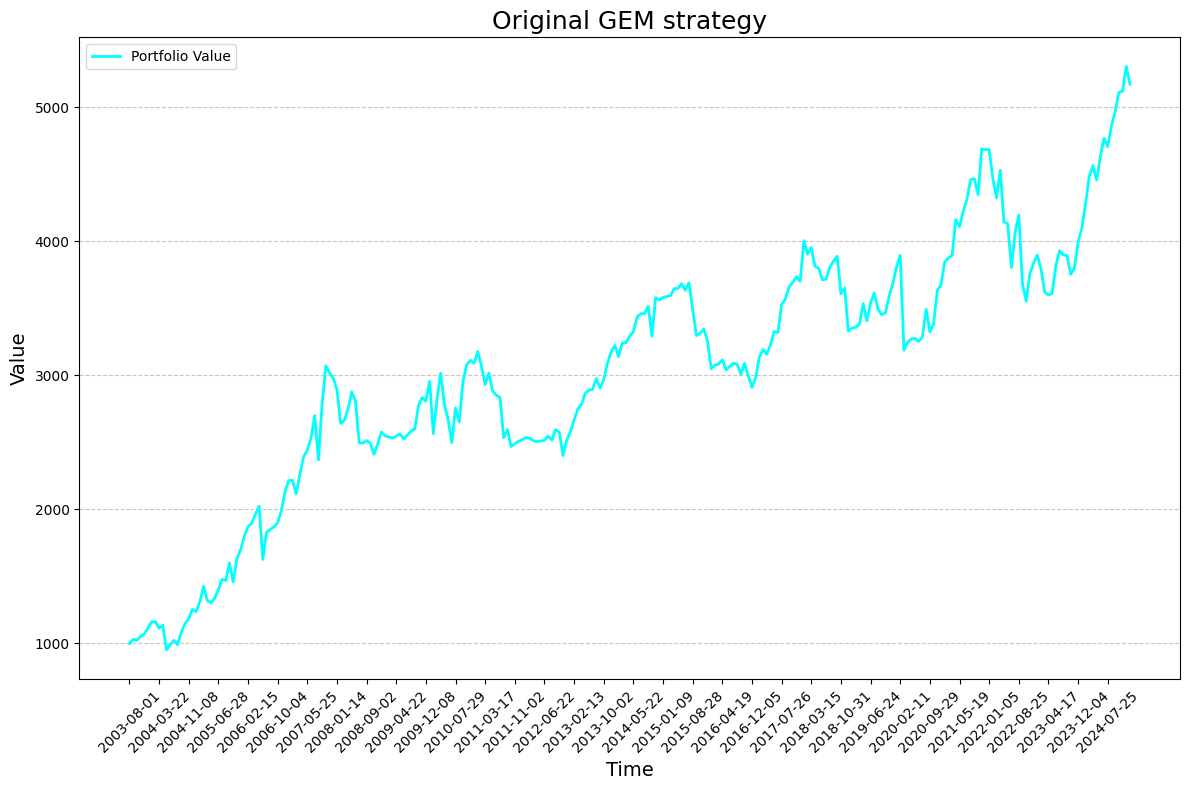

In [30]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365  # in days

gem_original_values, gem_original_days = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW
)
plot(gem_original_values, gem_original_days, "Original GEM strategy")

## GEM (Expanded Tickers)

The expanded GEM strategy extends the classic framework by including additional asset classes: QQQ (Nasdaq-100), TLT (long-term U.S. Treasuries), IAU (gold), and EUM (European equity proxy), alongside SPY, EEM, and BND. At each rebalancing window, the algorithm evaluates momentum across all seven ETFs, reallocating capital to the top performer. This broader approach aims to test momentum robustness in a multi-asset context by including alternative investments like gold and longer-duration bonds. Although more diversified, the expanded universe introduces additional switching complexity and may behave differently during various market conditions, offering insight into whether wider asset coverage can enhance or dampen traditional GEM results.

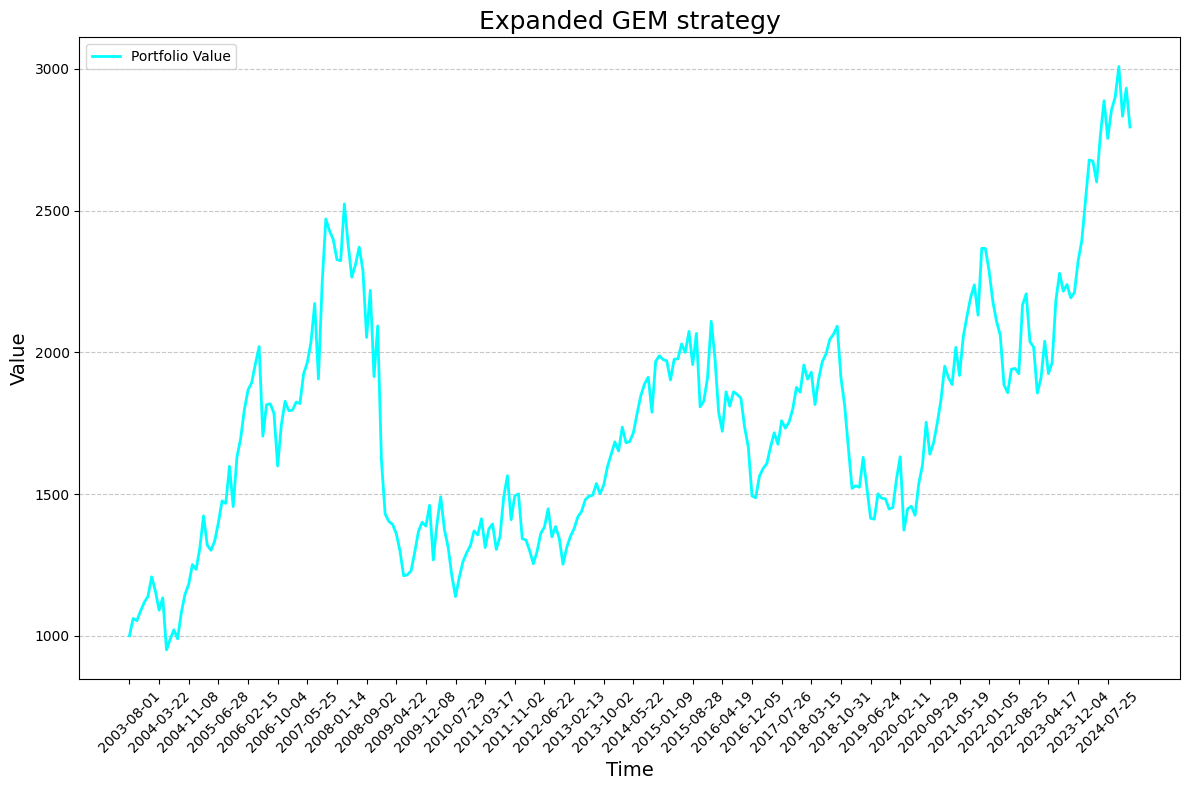

In [31]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365  # in days

all_gem_original_values, all_gem_original_days = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW, EXTENDED_TICKERS
)
plot(all_gem_original_values, all_gem_original_days, "Expanded GEM strategy")

## GEM with 90-Day Rebalancing 

This variant reduces the frequency of portfolio adjustments by rebalancing once per quarter (approximately 90 days) instead of monthly. While the classic GEM approach typically uses monthly rebalancing to capture momentum signals more dynamically, quarterly rebalancing offers potential advantages: reduced transaction costs, lower turnover, and less sensitivity to short-term market noise. Research suggests that less frequent rebalancing can still capture medium-term momentum trends while potentially improving risk-adjusted returns by avoiding whipsaw trades during volatile periods.

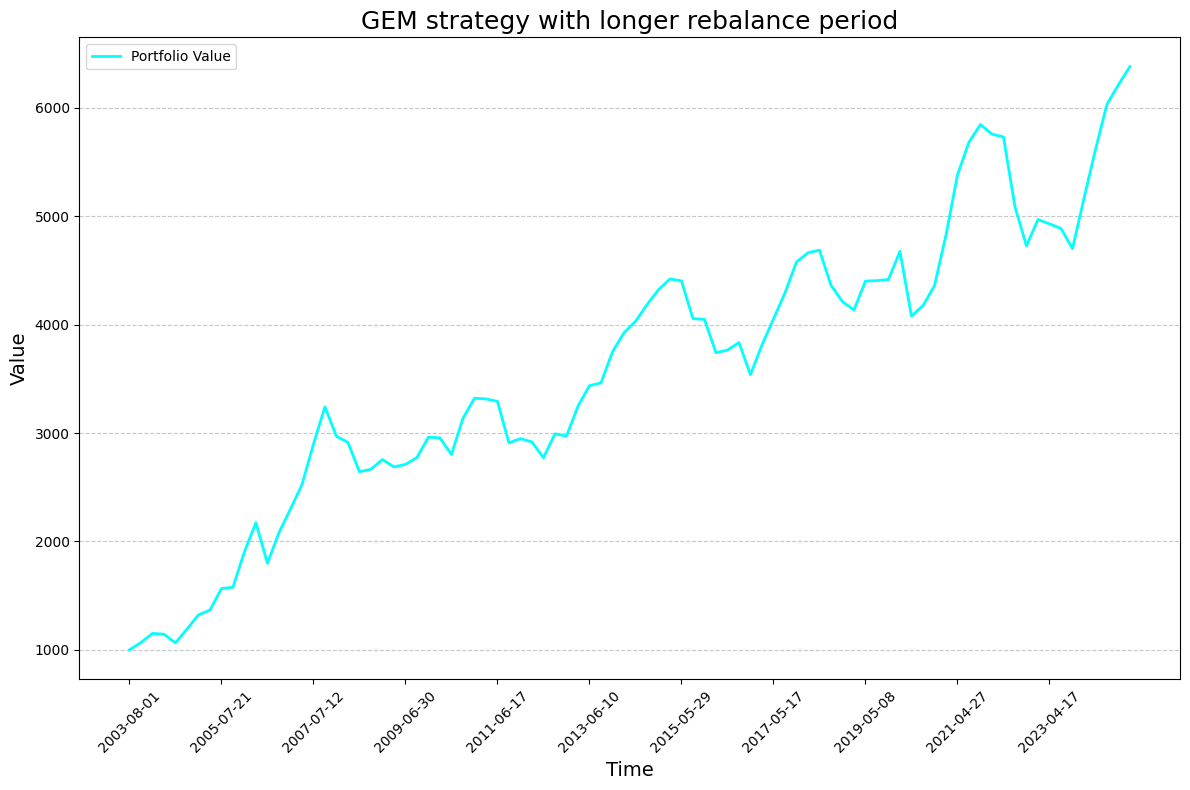

In [32]:
REBALANCE_PERIOD = 30 * 3  # in days
COMPARISON_TIME_WINDOW = 365  # in days

gem_values_long_period, gem_days_long_period = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW
)
plot(
    gem_values_long_period,
    gem_days_long_period,
    "GEM strategy with longer rebalance period",
)

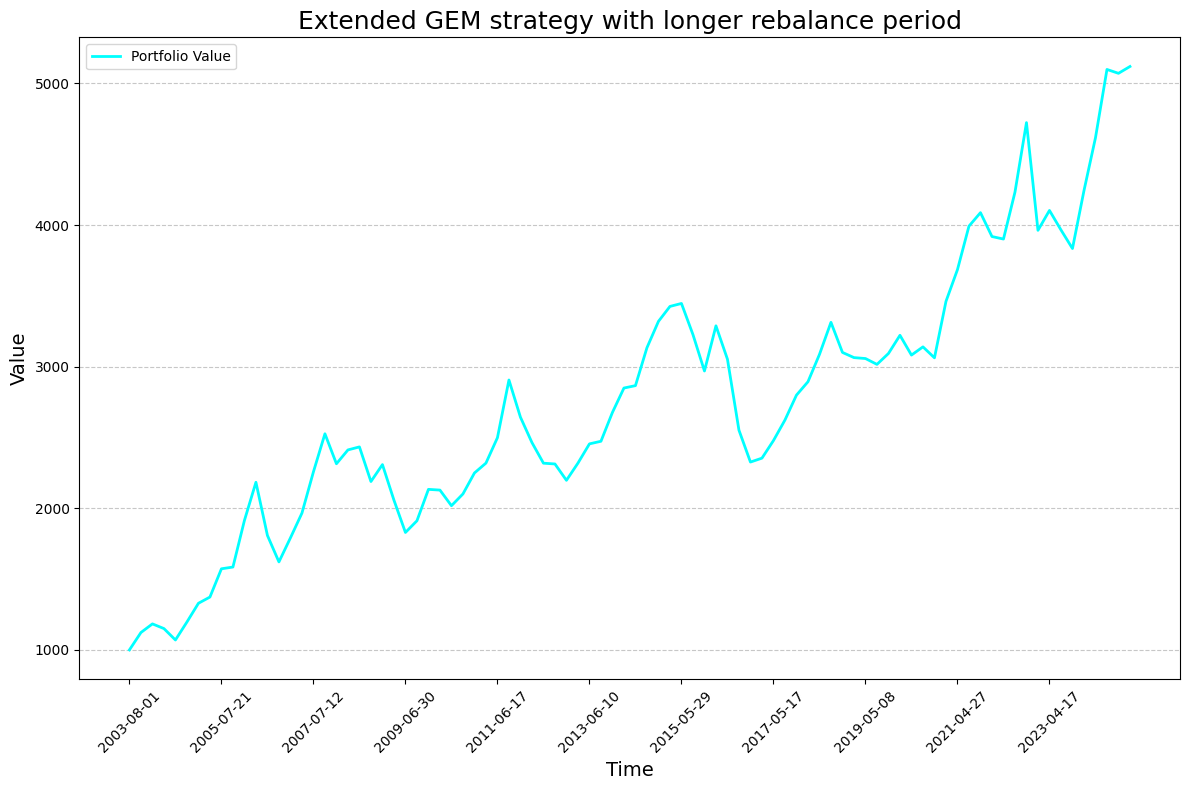

In [33]:
REBALANCE_PERIOD = 30 * 3  # in days
COMPARISON_TIME_WINDOW = 365  # in days

all_gem_values_long_period, all_gem_days_long_period = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW, EXTENDED_TICKERS
)
plot(
    all_gem_values_long_period,
    all_gem_days_long_period,
    "Extended GEM strategy with longer rebalance period",
)

## GEM with 15-Day Rebalancing Period

This variant tests a more aggressive rebalancing approach by updating portfolio positions every 15 days, approximately twice per month. Some momentum research suggests that rebalancing on multiple dates within a month—rather than once on a fixed date—can reduce timing risk and smooth out returns. The strategy maintains the standard 12-month lookback window but checks momentum signals more frequently, potentially capturing shorter-term trend shifts before they fully reverse.

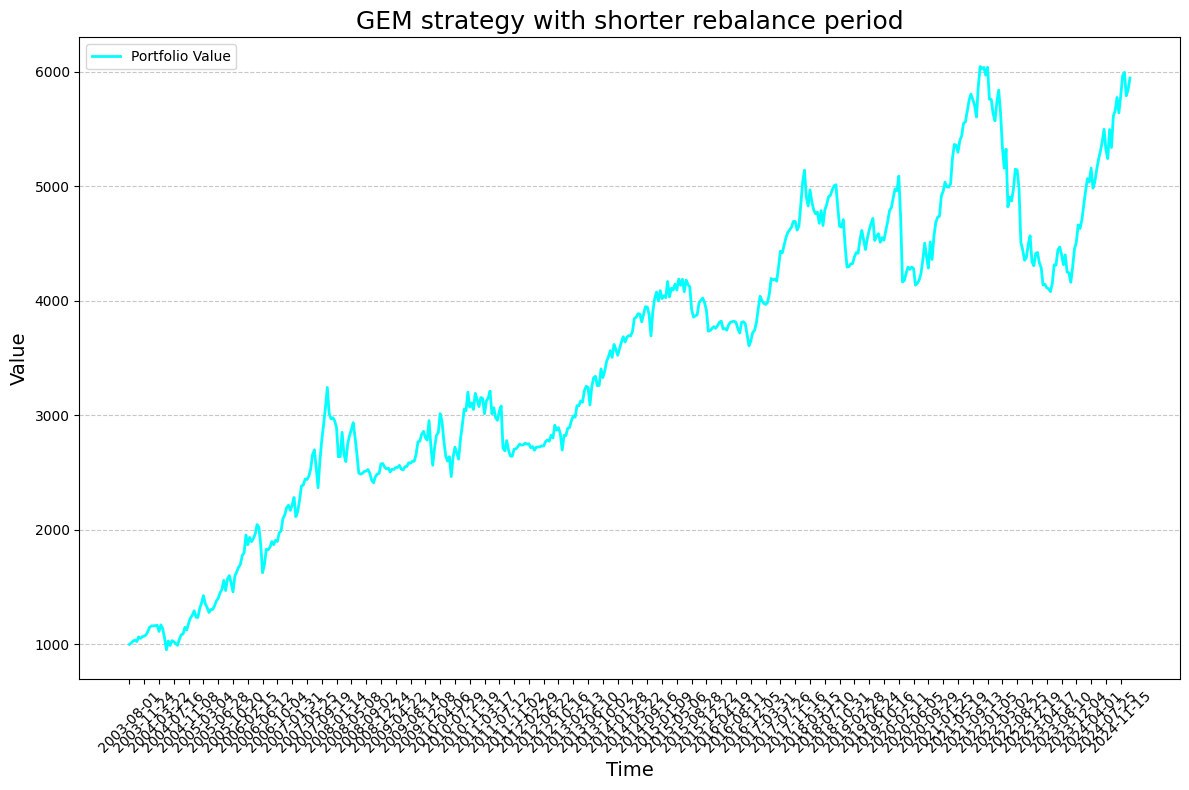

In [34]:
REBALANCE_PERIOD = 30 // 2  # in days
COMPARISON_TIME_WINDOW = 365  # in days

gem_values_short_period, gem_days_short_period = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW
)
plot(
    gem_values_short_period,
    gem_days_short_period,
    "GEM strategy with shorter rebalance period",
)

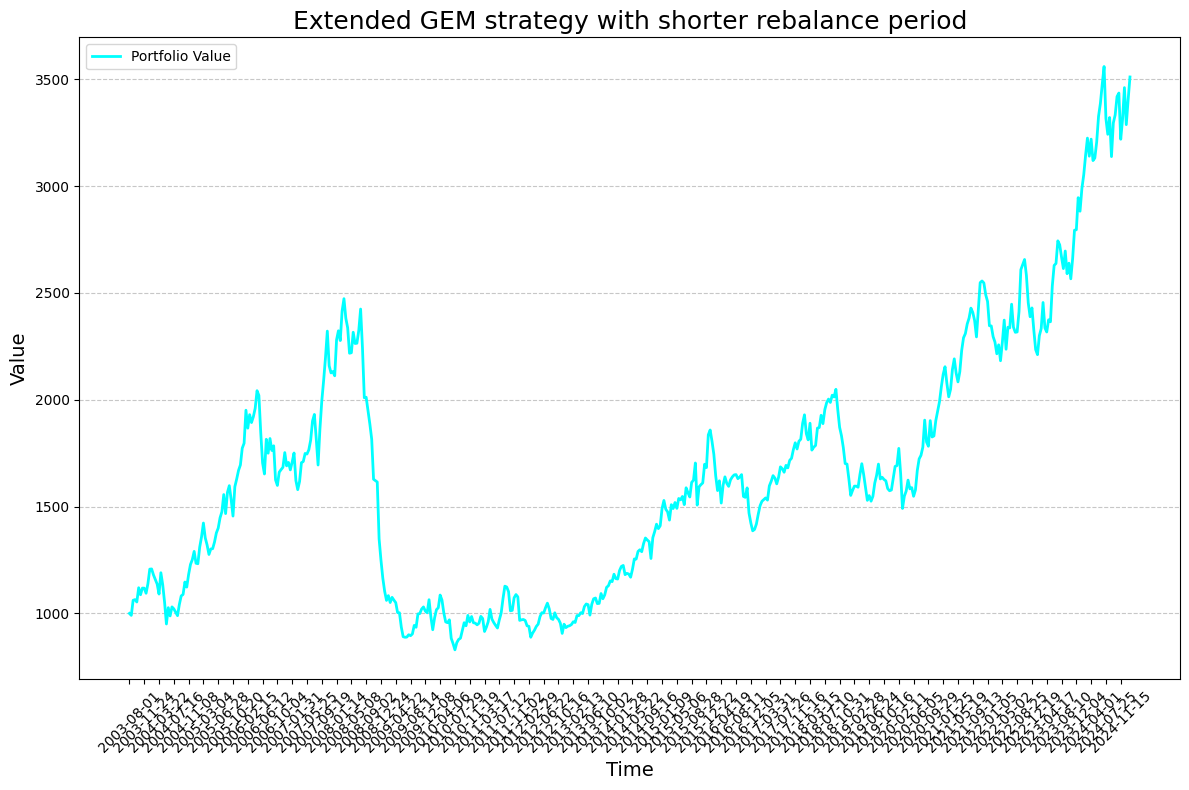

In [35]:
REBALANCE_PERIOD = 30 // 2  # in days
COMPARISON_TIME_WINDOW = 365  # in days

all_gem_values_short_period, all_gem_days_short_period = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW, EXTENDED_TICKERS
)
plot(
    all_gem_values_short_period,
    all_gem_days_short_period,
    "Extended GEM strategy with shorter rebalance period",
)

## GEM with 3-Year Comparison Time Window

This variant extends the lookback period to 36 months (3 years) while maintaining monthly rebalancing. Where the classic GEM uses a 12-month momentum window, this approach evaluates asset performance over a significantly longer horizon to capture multi-year trends and filter out shorter-term volatility. The strategy aims to identify more persistent, longer-term winners while potentially reducing the frequency of position switches caused by temporary market fluctuations.​

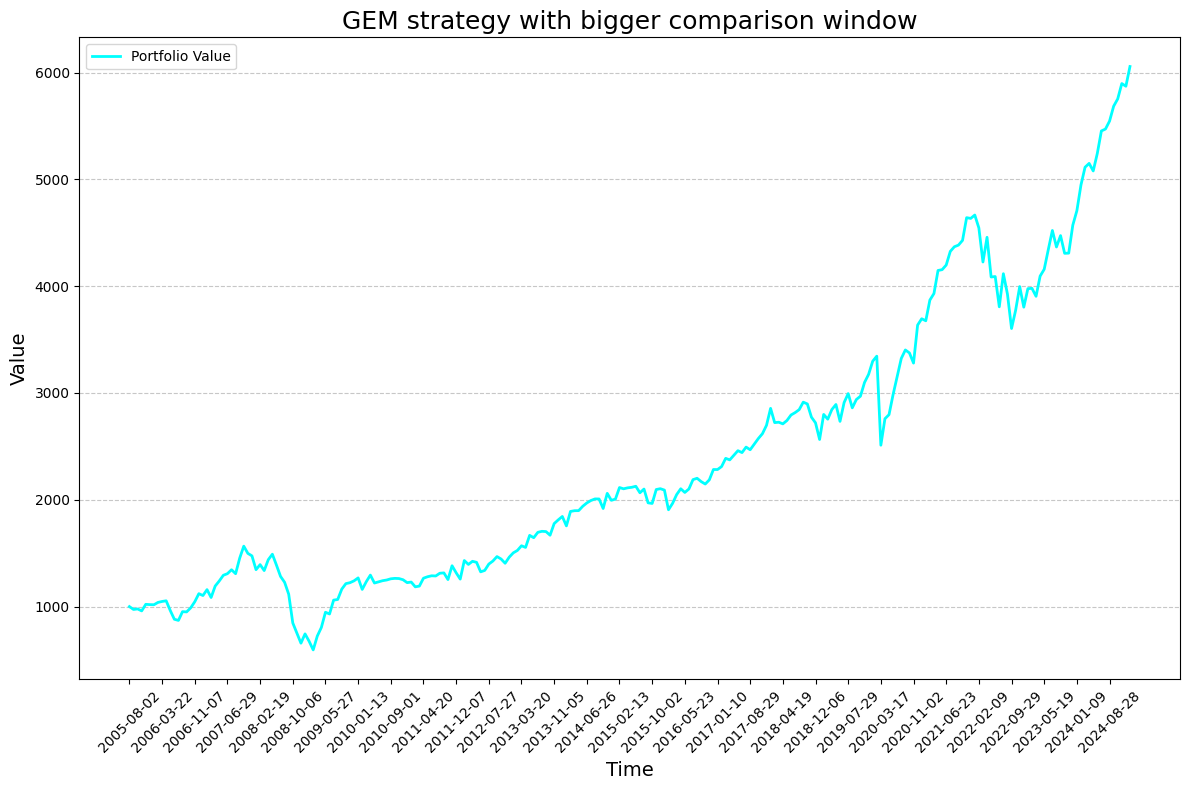

In [36]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365 * 3  # in days

gem_values_bigger_window, gem_days_bigger_window = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW
)
plot(
    gem_values_bigger_window,
    gem_days_bigger_window,
    "GEM strategy with bigger comparison window",
)

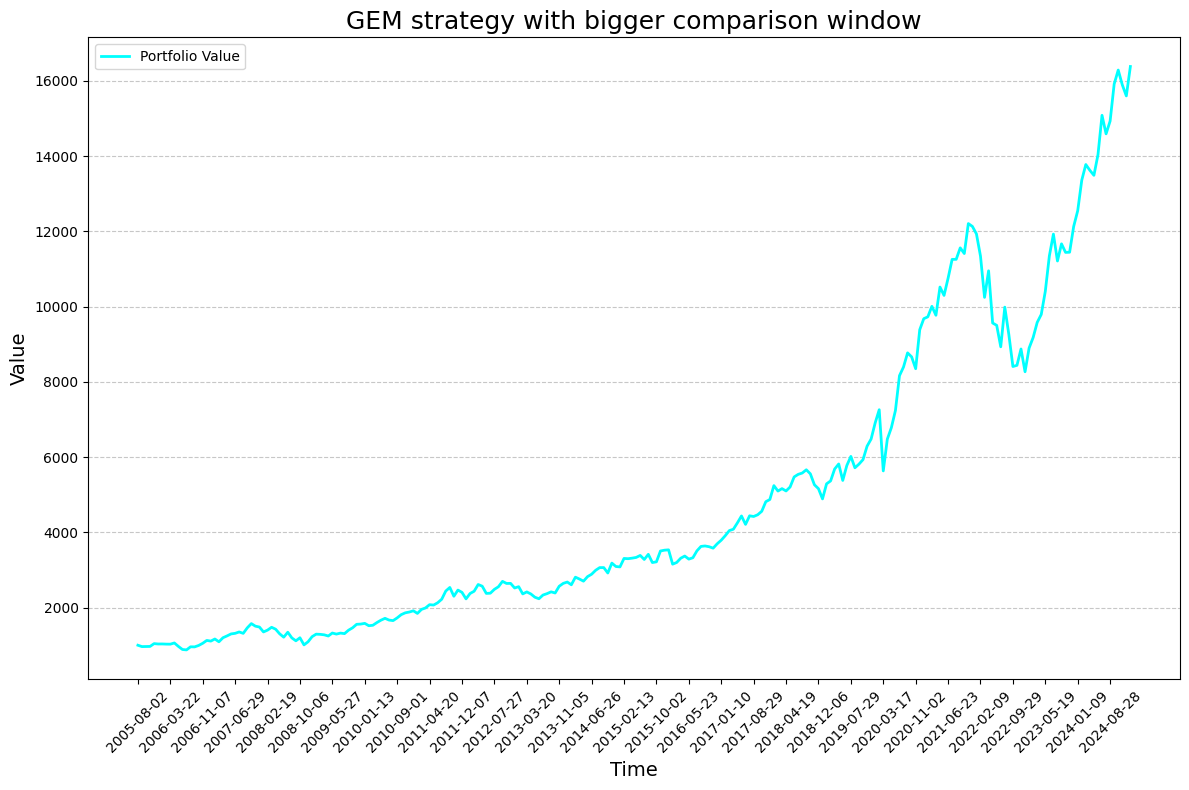

In [37]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365 * 3  # in days

all_gem_values_bigger_window, all_gem_days_bigger_window = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW, EXTENDED_TICKERS
)
plot(
    all_gem_values_bigger_window,
    all_gem_days_bigger_window,
    "GEM strategy with bigger comparison window",
)

## GEM with 6-Month Comparison Time Window

This variant shortens the lookback period to 6 months while maintaining monthly rebalancing, testing whether shorter-term momentum signals can enhance responsiveness to market trends. Research on momentum strategies indicates that momentum phenomena exist across various timeframes, with many studies finding significant effects at 6 to 12-month horizons. A 6-month window aims to capture more recent price trends and potentially react faster to changing market conditions compared to the traditional 12-month approach.

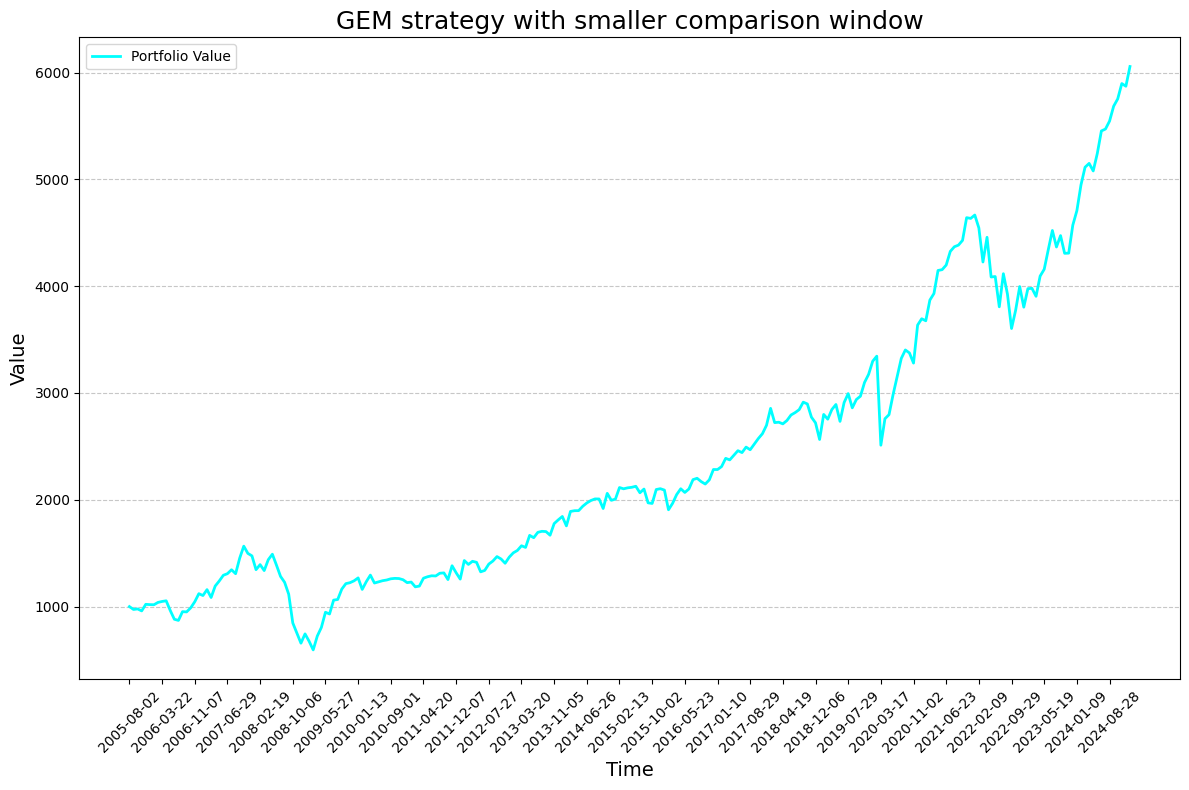

In [38]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365 * 3  # in days

gem_values_smaller_window, gem_days_smaller_window = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW
)
plot(
    gem_values_smaller_window,
    gem_days_smaller_window,
    "GEM strategy with smaller comparison window",
)

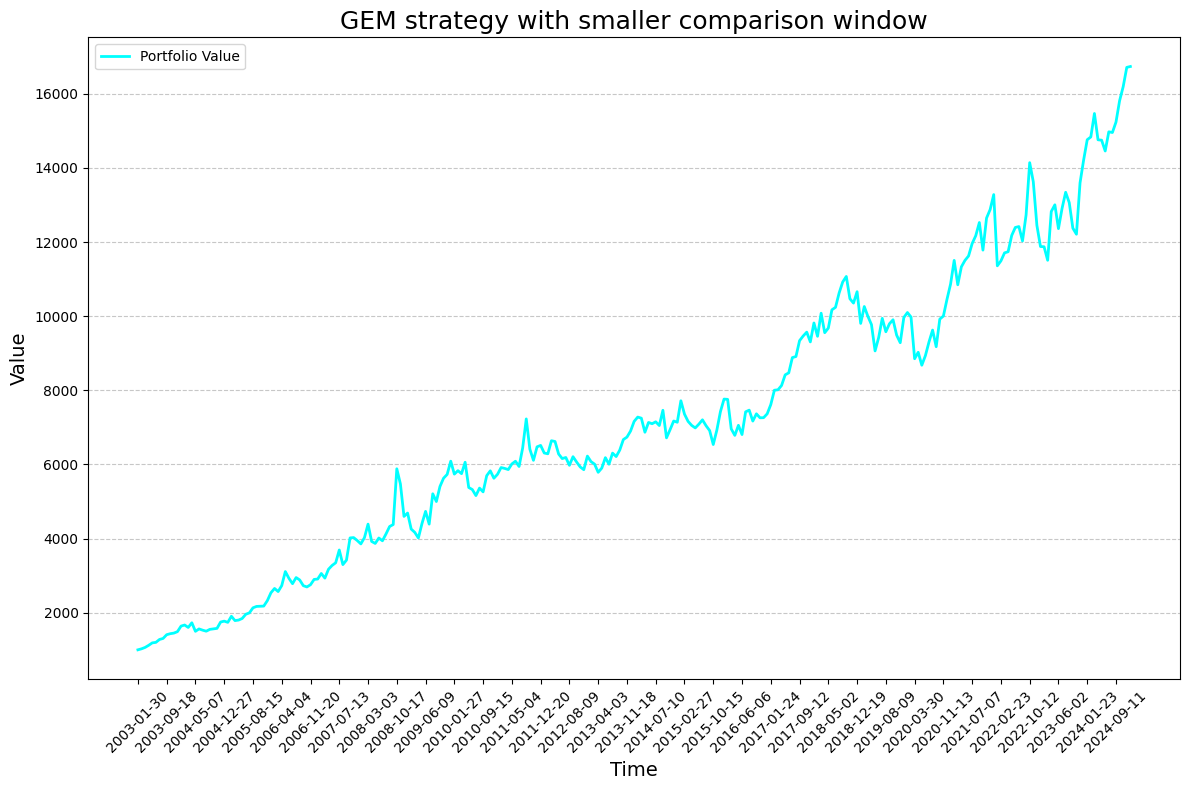

In [39]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365 // 2  # in days

all_gem_values_smaller_window, all_gem_days_smaller_window = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW, EXTENDED_TICKERS
)
plot(
    all_gem_values_smaller_window,
    all_gem_days_smaller_window,
    "GEM strategy with smaller comparison window",
)

## GEM Long-Term Trader

This variant targets long-term trend followers by combining quarterly rebalancing with a 3-year comparison window. Both parameters are tripled from the standard monthly/12-month GEM approach, creating a strategy designed for patient investors seeking to capture multi-year secular trends while minimizing trading activity. This configuration reduces transaction costs significantly—potentially executing only 4-5 trades per year—while focusing on assets demonstrating sustained, long-term momentum. The extended lookback period filters out medium-term volatility and market noise, identifying only the most persistent winners. However, this approach sacrifices responsiveness: the strategy may be slow to exit deteriorating positions or enter new trends, potentially missing shorter-term opportunities or enduring prolonged drawdowns during major market regime changes. This variant is ideal for testing whether a truly long-term, low-turnover momentum approach can match or exceed more active implementations.​

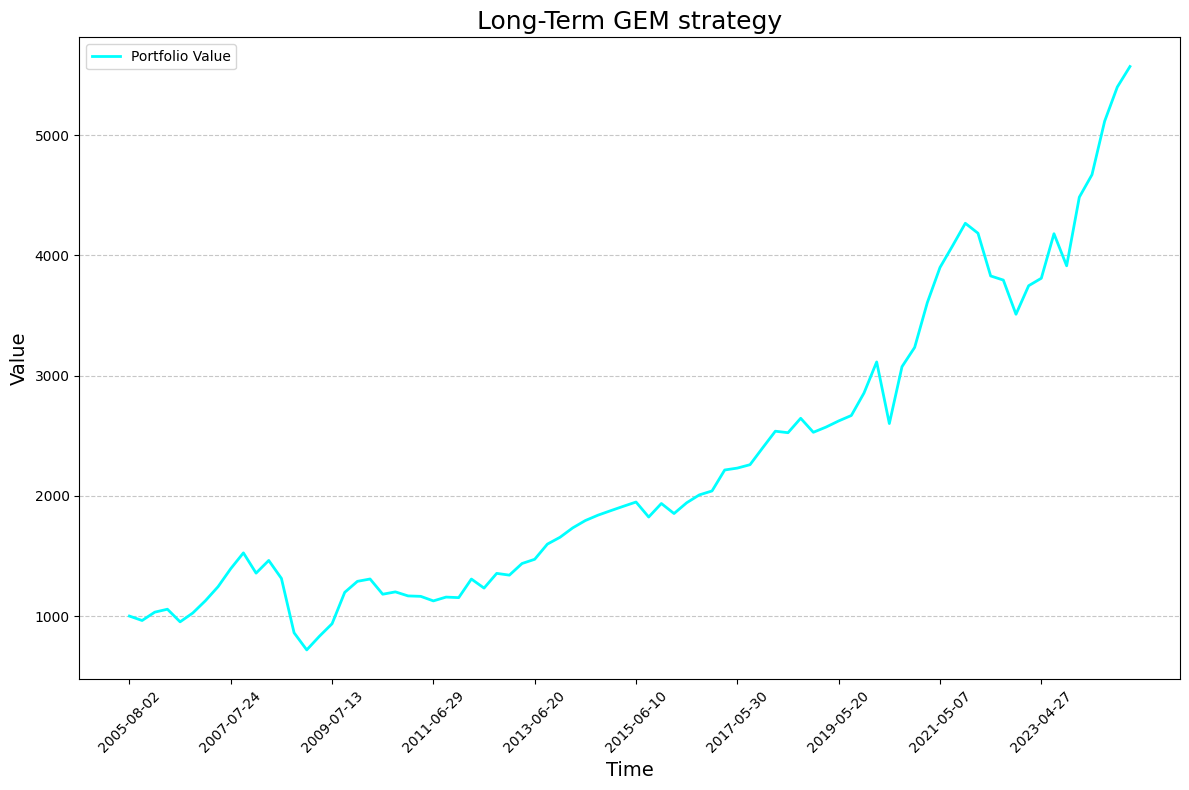

In [40]:
REBALANCE_PERIOD = 30 * 3 # in days
COMPARISON_TIME_WINDOW = 365 * 3  # in days

gem_values_long_term, gem_days_long_term = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW
)
plot(
    gem_values_long_term,
    gem_days_long_term,
    "Long-Term GEM strategy",
)

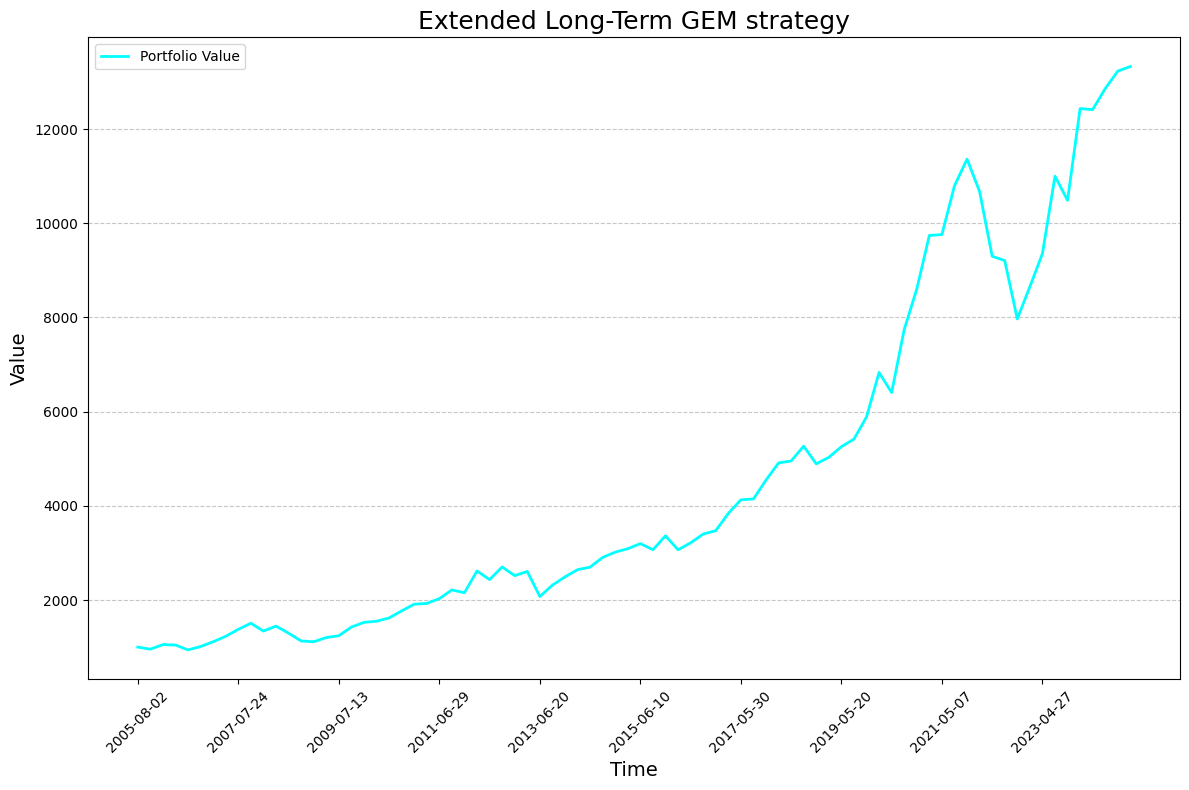

In [41]:
REBALANCE_PERIOD = 30 * 3 # in days
COMPARISON_TIME_WINDOW = 365 * 3  # in days

all_gem_values_long_term, all_gem_days_long_term = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW, EXTENDED_TICKERS
)
plot(
    all_gem_values_long_term,
    all_gem_days_long_term,
    "Extended Long-Term GEM strategy",
)

## GEM Short-Term Trader

This aggressive variant cuts both parameters in half, using 15-day rebalancing with a 6-month comparison window to capture shorter-term momentum signals and react quickly to changing market conditions. By evaluating recent performance over just six months and adjusting positions twice per month, this strategy aims to exploit faster-moving trends and exit positions earlier when momentum fades. Academic research shows momentum effects exist across various timeframes, with some studies finding profitability in periods ranging from one to twelve months. However, the short-term approach faces significant challenges: higher transaction costs from frequent trading, increased sensitivity to market noise and whipsaws during volatile periods, and the risk of overreacting to temporary price fluctuations rather than genuine trend shifts. This variant tests whether faster adaptation and more responsive positioning can generate superior risk-adjusted returns or simply add friction and instability to the momentum signal.​

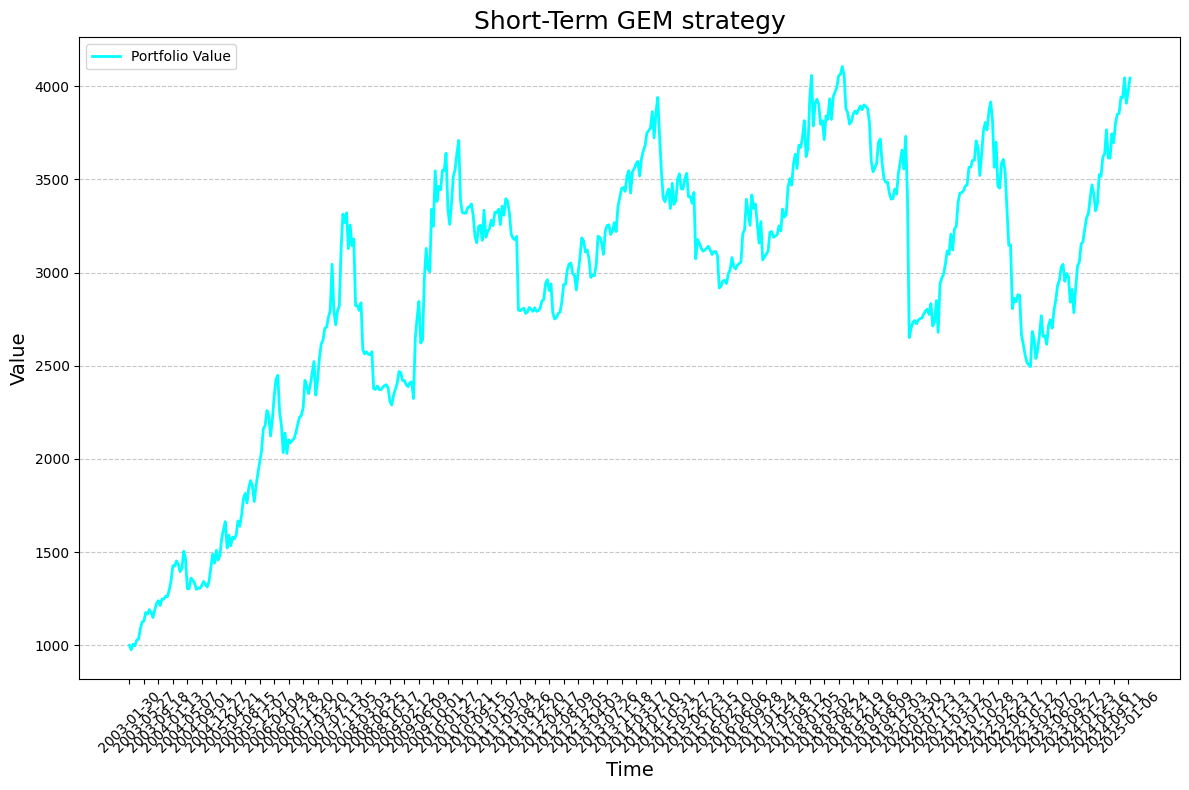

In [42]:
REBALANCE_PERIOD = 30 // 2 # in days
COMPARISON_TIME_WINDOW = 365 // 2 # in days

gem_values_short_term, gem_days_short_term = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW
)
plot(
    gem_values_short_term,
    gem_days_short_term,
    "Short-Term GEM strategy",
)

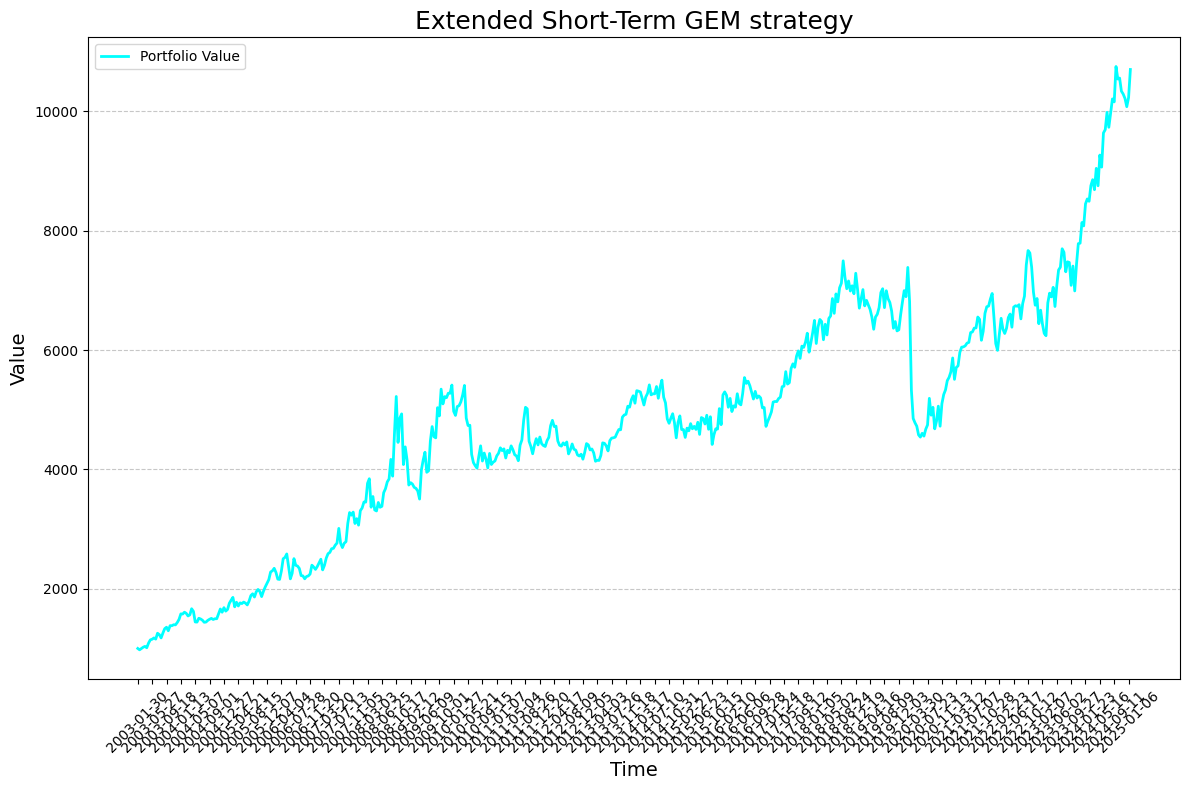

In [43]:
REBALANCE_PERIOD = 30 // 2 # in days
COMPARISON_TIME_WINDOW = 365 // 2 # in days

all_gem_values_short_term, all_gem_days_short_term = gem_sim(
    REBALANCE_PERIOD, COMPARISON_TIME_WINDOW, EXTENDED_TICKERS
)
plot(
    all_gem_values_short_term,
    all_gem_days_short_term,
    "Extended Short-Term GEM strategy",
)

## Statistics

In [44]:
def calculate_portfolio_statistics(values, days_of_investment):
    values = np.array(values)
    first_value = values[0]
    last_value = values[-1]
    first_day = datetime.strptime(days_of_investment[0], "%Y-%m-%d")
    last_day = datetime.strptime(days_of_investment[-1], "%Y-%m-%d")
    time_in_days = (last_day - first_day).days
    time_in_years = time_in_days / 365.25

    # Daily returns
    daily_returns = np.diff(values) / values[:-1] * 100  # in percentages

    # 1. Total return
    total_return = ((last_value - first_value) / first_value) * 100

    # 2. Compound Annual Growth Rate (CAGR)
    if time_in_years > 0:
        cagr = (((last_value / first_value) ** (1 / time_in_years)) - 1) * 100
    else:
        cagr = 0

    # 3. Volatility - annual
    daily_volatility = np.std(daily_returns)
    annual_volatility = daily_volatility * np.sqrt(365.25)

    # 4. Maximum drawdown
    cumulative_max = np.maximum.accumulate(values)
    drawdowns = (values - cumulative_max) / cumulative_max * 100
    max_drawdown = np.min(drawdowns)

    # 5-7. Rising and falling days
    rising_days = np.sum(daily_returns > 0)
    falling_days = np.sum(daily_returns < 0)
    flat_days = np.sum(daily_returns == 0)

    # 8. Average daily return (all days)
    avg_daily_return = np.mean(daily_returns)

    # 9. Average daily gain (only rising days)
    positive_returns = daily_returns[daily_returns > 0]
    avg_daily_gain = np.mean(positive_returns) if len(positive_returns) > 0 else 0

    # 10. Average daily loss (only falling days)
    negative_returns = daily_returns[daily_returns < 0]
    avg_daily_loss = np.mean(negative_returns) if len(negative_returns) > 0 else 0

    # ADDITIONAL STATISTICS:

    # 11. Sharpe Ratio (assuming risk-free rate = 0)
    # You can adjust risk_free_rate to current market conditions
    risk_free_rate = 0  # in %
    if annual_volatility != 0:
        sharpe_ratio = (cagr - risk_free_rate) / annual_volatility
    else:
        sharpe_ratio = 0

    # 12. Sortino Ratio (only downside volatility)
    excess_returns = daily_returns - (risk_free_rate / 365.25)
    downside_returns = excess_returns[excess_returns < 0]
    downside_volatility = (
        np.std(downside_returns) * np.sqrt(365.25) if len(downside_returns) > 0 else 0
    )
    if downside_volatility != 0:
        sortino_ratio = (cagr - risk_free_rate) / downside_volatility
    else:
        sortino_ratio = 0

    # 13. Calmar Ratio (CAGR / |Max Drawdown|)
    if max_drawdown != 0:
        calmar_ratio = cagr / abs(max_drawdown)
    else:
        calmar_ratio = 0

    # 14. Maximum consecutive gains/losses
    def max_consecutive(arr, condition):
        if len(arr) == 0:
            return 0
        mask = condition(arr)
        padded = np.concatenate(([False], mask, [False]))
        edges = np.diff(padded.astype(int))
        starts = np.where(edges == 1)[0]
        ends = np.where(edges == -1)[0]
        if len(starts) == 0:
            return 0
        return np.max(ends - starts)

    max_consecutive_gains = max_consecutive(daily_returns, lambda x: x > 0)
    max_consecutive_losses = max_consecutive(daily_returns, lambda x: x < 0)

    # 15. Percentage of rising days
    win_rate = (rising_days / len(daily_returns)) * 100 if len(daily_returns) > 0 else 0

    # 16. Profit Factor (sum of gains / sum of losses)
    total_gains = np.sum(positive_returns)
    total_losses = abs(np.sum(negative_returns))
    profit_factor = total_gains / total_losses if total_losses != 0 else 0

    # 17. Best and worst daily return
    best_day = np.max(daily_returns) if len(daily_returns) > 0 else 0
    worst_day = np.min(daily_returns) if len(daily_returns) > 0 else 0

    # 18. Time to recover from max drawdown (recovery time)
    max_dd_idx = np.argmin(drawdowns)
    recovery_time = None
    if max_dd_idx < len(values) - 1:
        peak_value = cumulative_max[max_dd_idx]
        recovery_idx = np.where(values[max_dd_idx:] >= peak_value)[0]
        if len(recovery_idx) > 0:
            recovery_days = recovery_idx[0]
            recovery_time = recovery_days

    return {
        # Basic metrics
        "total_return [%]": round(total_return, 2),
        "cagr [%]": round(cagr, 2),
        "annual_volatility": round(annual_volatility, 2),
        "max_drawdown [%]": round(max_drawdown, 2),
        "-": "---",
        # Daily statistics
        "rising_days": int(rising_days),
        "falling_days": int(falling_days),
        "flat_days": int(flat_days),
        "avg_daily_return": round(avg_daily_return, 3),
        "avg_daily_gain": round(avg_daily_gain, 3),
        "avg_daily_loss": round(avg_daily_loss, 3),
        "best_day": round(best_day, 2),
        "worst_day": round(worst_day, 2),
        "--": "---",
        # Risk metrics
        "sharpe_ratio": round(sharpe_ratio, 3),
        "sortino_ratio": round(sortino_ratio, 3),
        "calmar_ratio": round(calmar_ratio, 3),
        "---": "---",
        # Additional statistics
        "win_rate": round(win_rate, 2),
        "profit_factor": round(profit_factor, 3),
        "max_consecutive_gains": int(max_consecutive_gains),
        "max_consecutive_losses": int(max_consecutive_losses),
        "recovery_time_days": recovery_time,
        "----": "---",
        # General information
        "total_days": time_in_days,
        "total_years": round(time_in_years, 2),
        "initial_value": round(first_value, 2),
        "final_value": round(last_value, 2),
    }


portfolios = {
    "Buy and hold": {"values": buy_and_hold_values, "days": buy_and_hold_days},
    "Gem (Original)": {"values": gem_original_values, "days": gem_original_days},
    "Gem (Extended)": {
        "values": all_gem_original_values,
        "days": all_gem_original_days,
    },
    "Long period": {"values": gem_values_long_period, "days": gem_days_long_period},
    "Long period (Extended)": {
        "values": all_gem_values_long_period,
        "days": all_gem_days_long_period,
    },
    "Short period": {"values": gem_values_short_period, "days": gem_days_short_period},
    "Short period (Extended)": {
        "values": all_gem_values_short_period,
        "days": all_gem_days_short_period,
    },
    "Big window": {"values": gem_values_bigger_window, "days": gem_days_bigger_window},
    "Big window (Extended)": {
        "values": all_gem_values_bigger_window,
        "days": all_gem_days_bigger_window,
    },
    "Small window": {"values": gem_values_smaller_window, "days": gem_days_smaller_window},
    "Small window (Extended)": {
        "values": all_gem_values_smaller_window,
        "days": all_gem_days_smaller_window,
    },
    "Long-term": {"values": gem_values_long_term, "days": gem_days_long_term},
    "Long-term (Extended)": {
        "values": all_gem_values_long_term,
        "days": all_gem_days_long_term,
    },
    "Short-term": {"values": gem_values_short_term, "days": gem_days_short_term},
    "Short-term (Extended)": {
        "values": all_gem_values_short_term,
        "days": all_gem_days_short_term,
    },
}

results = {}

for key, value in portfolios.items():
    stats = calculate_portfolio_statistics(value["values"], value["days"])
    results[key] = stats

# Transpose so portfolios are in columns
df_results = pd.DataFrame(results)
df_results = df_results.round(3)
print(df_results.to_string())

                       Buy and hold Gem (Original) Gem (Extended) Long period Long period (Extended) Short period Short period (Extended) Big window Big window (Extended) Small window Small window (Extended) Long-term Long-term (Extended) Short-term Short-term (Extended)
total_return [%]             500.59         416.96         179.47      538.15                 411.97       494.73                  251.12     505.61               1538.41       505.61                 1573.58    456.98              1232.69     304.43                970.07
cagr [%]                       8.71           7.96           4.91        9.03                   7.92         8.65                    6.01       9.69                 15.44         9.69                   13.71      9.22                14.23       6.56                 11.39
annual_volatility             98.04          89.34         108.88      133.36                 151.61        58.01                   71.25     101.99                  99.3       101.99 